# 📊 Análise de Ocorrências Internas - Seguradora de Convênio Médico

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Carregar dados brutos
df = pd.read_csv('../data/raw/dados_ocorrencias_seguradora.csv')
df['data_ocorrencia'] = pd.to_datetime(df['data_ocorrencia'])
df.head()

,data_ocorrencia,tipo_problema,tempo_resolucao,canal_entrada,classificacao,responsavel_setor,cliente_reincidente
0,2024-06-12,erro sistema,7,telefone,média,Setor A,não
1,2024-01-29,cancelamento indevido,5,telefone,média,Setor C,não
2,2024-01-07,atraso na resposta,6,app,crítica,Setor A,sim
3,2024-03-11,cancelamento indevido,4,telefone,baixa,Setor A,não
4,2024-03-03,cancelamento indevido,5,presencial,baixa,Setor A,sim


In [3]:
print(df.info())
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   data_ocorrencia      500 non-null    datetime64[ns]
 1   tipo_problema        500 non-null    object        
 2   tempo_resolucao      500 non-null    int64         
 3   canal_entrada        500 non-null    object        
 4   classificacao        500 non-null    object        
 5   responsavel_setor    500 non-null    object        
 6   cliente_reincidente  500 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 27.5+ KB
None


,data_ocorrencia,tipo_problema,tempo_resolucao,canal_entrada,classificacao,responsavel_setor,cliente_reincidente
count,500,500,500.000000,500,500,500,500
unique,NaN,5,NaN,4,3,3,2
top,NaN,erro sistema,NaN,telefone,baixa,Setor B,não
freq,NaN,112,NaN,138,245,175,346
mean,2024-03-27 23:39:50.400000256,NaN,4.500000,NaN,NaN,NaN,NaN
min,2024-01-01 00:00:00,NaN,1.000000,NaN,NaN,NaN,NaN
25%,2024-02-10 00:00:00,NaN,3.000000,NaN,NaN,NaN,NaN
50%,2024-03-23 12:00:00,NaN,4.000000,NaN,NaN,NaN,NaN
75%,2024-05-17 00:00:00,NaN,6.000000,NaN,NaN,NaN,NaN
max,2024-06-29 00:00:00,NaN,11.000000,NaN,NaN,NaN,NaN


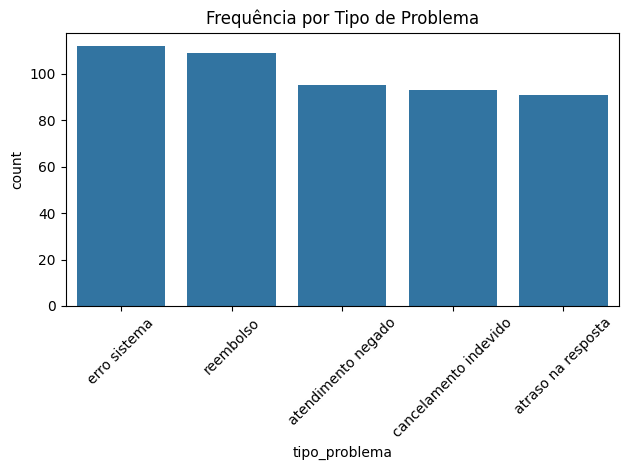

In [4]:

sns.countplot(data=df, x='tipo_problema', order=df['tipo_problema'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Frequência por Tipo de Problema')
plt.tight_layout()
plt.show()


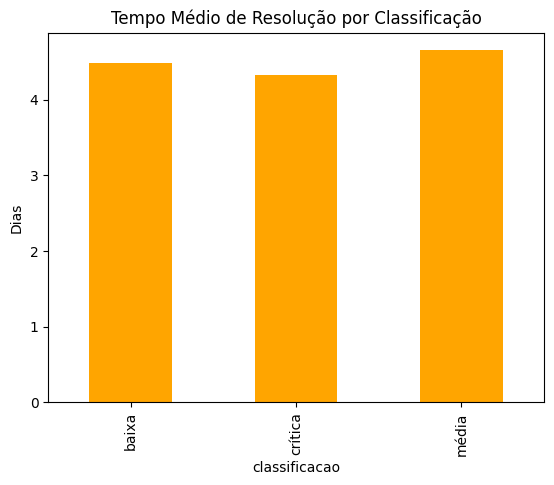

In [5]:

df.groupby('classificacao')['tempo_resolucao'].mean().plot(kind='bar', color='orange')
plt.title('Tempo Médio de Resolução por Classificação')
plt.ylabel('Dias')
plt.show()


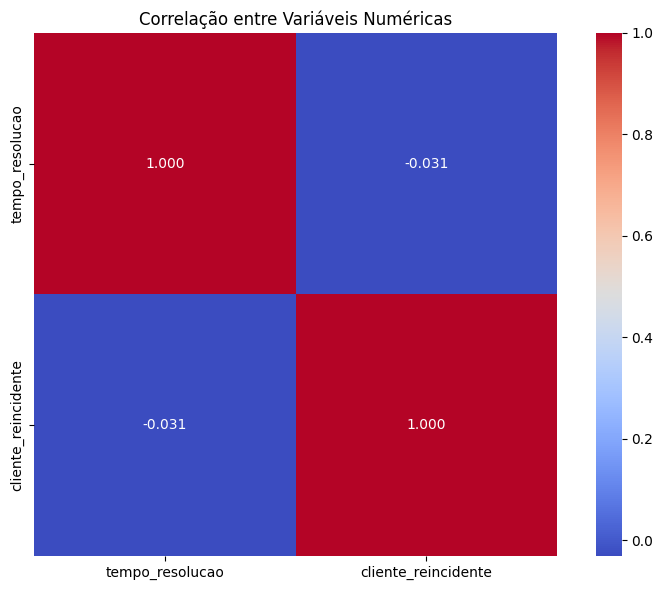

In [6]:
# Análise de correlação
df_encoded = df.copy()
df_encoded['cliente_reincidente'] = df_encoded['cliente_reincidente'].map({'sim': 1, 'não': 0})

# Criar figura maior para melhor visualização
plt.figure(figsize=(8, 6))
sns.heatmap(df_encoded[['tempo_resolucao', 'cliente_reincidente']].corr(), 
            annot=True, cmap='coolwarm', fmt='.3f', square=True)
plt.title('Correlação entre Variáveis Numéricas')
plt.tight_layout()
plt.show()

In [7]:
# Preparação dos dados para Machine Learning
df_ml = df_encoded.copy()

# Separar a variável target antes de aplicar get_dummies
y = df_ml['classificacao']

# Aplicar get_dummies apenas nas variáveis features, excluindo colunas não relevantes
X = pd.get_dummies(df_ml.drop(['data_ocorrencia', 'responsavel_setor', 'classificacao'], axis=1))

# Dividir em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

print(f"Shape do conjunto de treino: {X_train.shape}")
print(f"Shape do conjunto de teste: {X_test.shape}")
print(f"Distribuição das classes no treino:\n{y_train.value_counts()}")

Shape do conjunto de treino: (350, 11)
Shape do conjunto de teste: (150, 11)
Distribuição das classes no treino:
classificacao
baixa      172
média      106
crítica     72
Name: count, dtype: int64


In [8]:
# Treinamento do modelo RandomForest
modelo = RandomForestClassifier(random_state=42, n_estimators=100)
modelo.fit(X_train, y_train)

# Predições
y_pred = modelo.predict(X_test)

# Avaliação
print('📊 Relatório de Classificação:')
print(classification_report(y_test, y_pred))
print(f"\nAcurácia do modelo: {accuracy_score(y_test, y_pred):.3f}")

📊 Relatório de Classificação:
              precision    recall  f1-score   support

       baixa       0.54      0.59      0.56        73
     crítica       0.20      0.26      0.22        31
       média       0.34      0.22      0.27        46

    accuracy                           0.41       150
   macro avg       0.36      0.35      0.35       150
weighted avg       0.41      0.41      0.40       150


Acurácia do modelo: 0.407


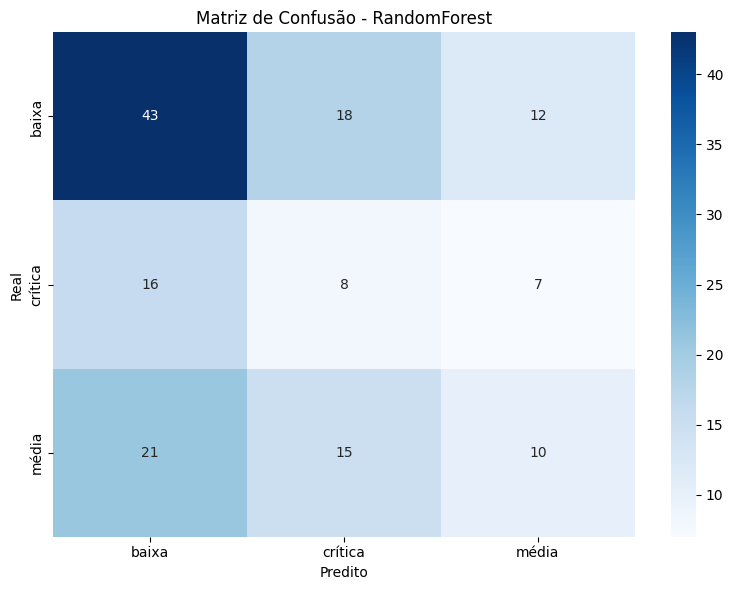

In [9]:
# Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=modelo.classes_, yticklabels=modelo.classes_)
plt.title('Matriz de Confusão - RandomForest')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

In [17]:
# Exportar dados formatados para uso nos dashboards
output_file = '../data/processed/dados_ocorrencias_formatado.csv'
df.to_csv(output_file, index=False, encoding='utf-8')
print(f'✅ Arquivo exportado com sucesso: {output_file}')
print(f'Total de registros: {len(df)}')

✅ Arquivo exportado com sucesso: ../data/processed/dados_ocorrencias_formatado.csv
Total de registros: 500


## 🔍 Análise da Performance e Teste de Outros Modelos

A performance do RandomForest foi baixa (37% de acurácia). Vamos testar outros algoritmos e técnicas de melhoria.

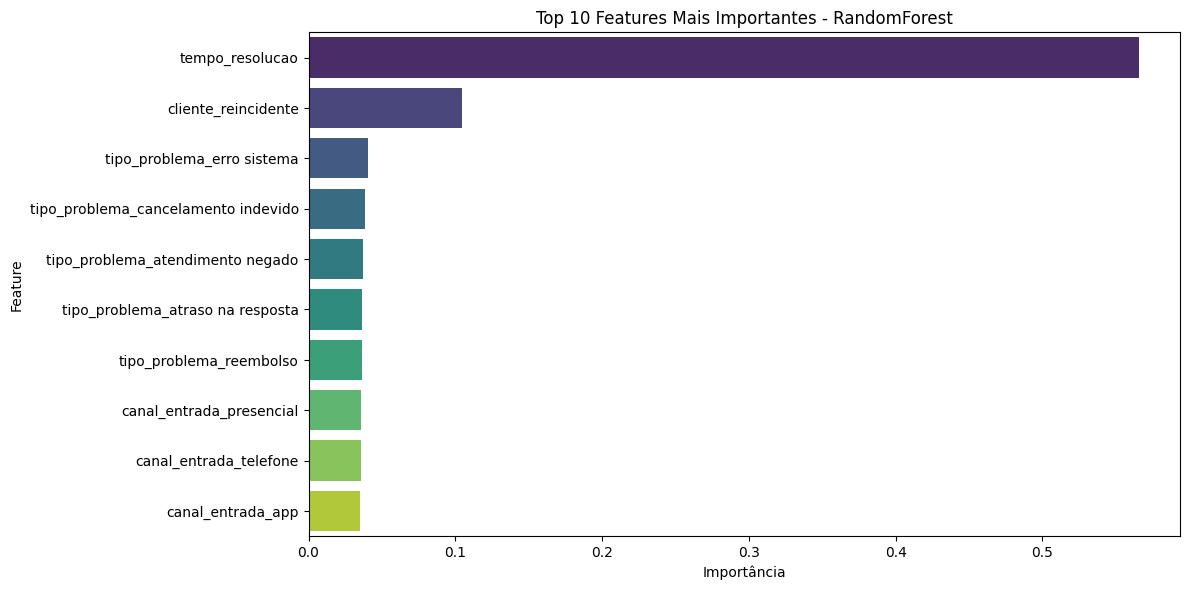

📊 Features mais importantes:
                                feature  importance
0                       tempo_resolucao    0.565420
1                   cliente_reincidente    0.104452
5            tipo_problema_erro sistema    0.040808
4   tipo_problema_cancelamento indevido    0.038770
2      tipo_problema_atendimento negado    0.037089
3      tipo_problema_atraso na resposta    0.036537
6               tipo_problema_reembolso    0.036130
9              canal_entrada_presencial    0.035800
10               canal_entrada_telefone    0.035494
7                     canal_entrada_app    0.035075


In [11]:
# Análise de importância das features no RandomForest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': modelo.feature_importances_
}).sort_values('importance', ascending=False)

# Visualização
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')
plt.title('Top 10 Features Mais Importantes - RandomForest')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("📊 Features mais importantes:")
print(feature_importance.head(10).to_string())

🔄 Testando diferentes modelos...

Treinando Random Forest...
✅ Random Forest: 0.407

Treinando Gradient Boosting...
✅ Gradient Boosting: 0.453

Treinando SVM...
✅ SVM: 0.487

Treinando Logistic Regression...
✅ Logistic Regression: 0.467

Treinando KNN...
✅ KNN: 0.387



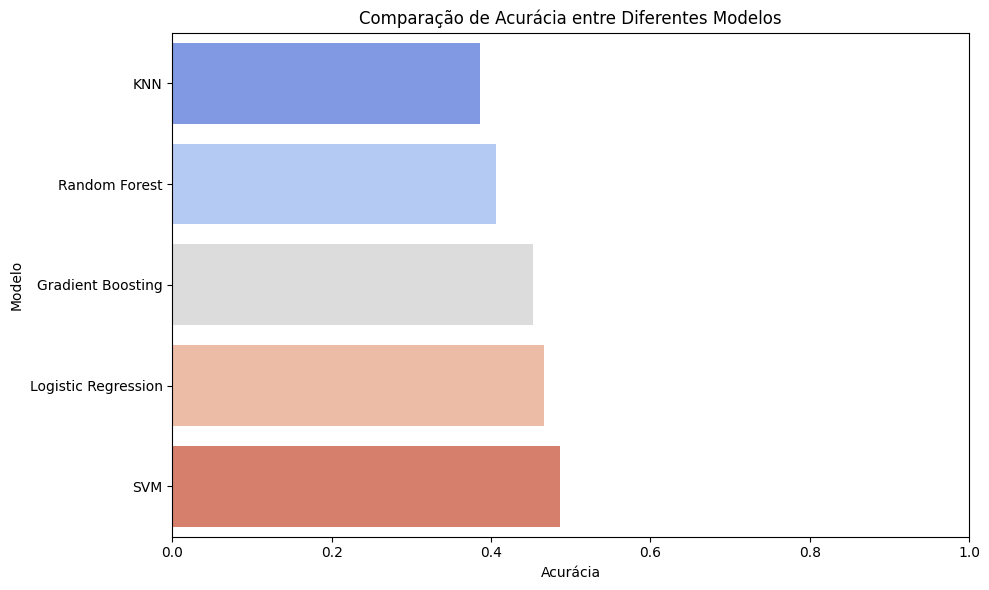


🏆 Melhor modelo: SVM com 0.487 de acurácia


In [12]:
# Comparação de diferentes algoritmos de Machine Learning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Dicionário com diferentes modelos
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, kernel='rbf'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Testando cada modelo
print("🔄 Testando diferentes modelos...\n")
resultados = {}
for nome, modelo_teste in modelos.items():
    print(f"Treinando {nome}...")
    modelo_teste.fit(X_train, y_train)
    y_pred_teste = modelo_teste.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_teste)
    resultados[nome] = accuracy
    print(f"✅ {nome}: {accuracy:.3f}\n")

# Visualizando os resultados
resultados_df = pd.DataFrame(list(resultados.items()), columns=['Modelo', 'Acurácia'])
resultados_df = resultados_df.sort_values('Acurácia', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=resultados_df, x='Acurácia', y='Modelo', palette='coolwarm')
plt.title('Comparação de Acurácia entre Diferentes Modelos')
plt.xlabel('Acurácia')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

print(f"\n🏆 Melhor modelo: {resultados_df.iloc[-1]['Modelo']} com {resultados_df.iloc[-1]['Acurácia']:.3f} de acurácia")

In [13]:
# Melhorando o RandomForest com hiperparâmetros otimizados
rf_melhorado = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',  # Para lidar com desbalanceamento de classes
    max_features='sqrt'
)

print("🔧 Treinando RandomForest Melhorado...")
rf_melhorado.fit(X_train, y_train)
y_pred_melhorado = rf_melhorado.predict(X_test)

print('\n📊 Relatório de Classificação - RandomForest Melhorado:')
print(classification_report(y_test, y_pred_melhorado))

# Comparação detalhada
print(f"\n📈 Comparação de Performance:")
print(f"RandomForest Original: {accuracy_score(y_test, y_pred):.3f}")
print(f"RandomForest Melhorado: {accuracy_score(y_test, y_pred_melhorado):.3f}")
print(f"Melhoria: {(accuracy_score(y_test, y_pred_melhorado) - accuracy_score(y_test, y_pred)):.3f}")

🔧 Treinando RandomForest Melhorado...

📊 Relatório de Classificação - RandomForest Melhorado:
              precision    recall  f1-score   support

       baixa       0.53      0.38      0.44        73
     crítica       0.19      0.35      0.25        31
       média       0.30      0.26      0.28        46

    accuracy                           0.34       150
   macro avg       0.34      0.33      0.32       150
weighted avg       0.39      0.34      0.35       150


📈 Comparação de Performance:
RandomForest Original: 0.407
RandomForest Melhorado: 0.340
Melhoria: -0.067


In [14]:
# Diagnóstico dos dados e possíveis problemas
print("🔍 Análise de Diagnóstico dos Dados\n")
print("=" * 60)

print("\n1️⃣ Distribuição das classes na variável target:")
print(y.value_counts())
print(f"\nPercentual por classe:")
print((y.value_counts(normalize=True) * 100).round(2))

print(f"\n2️⃣ Dimensões dos dados:")
print(f"Número de features: {X.shape[1]}")
print(f"Número de amostras: {X.shape[0]}")
print(f"Razão features/amostras: {X.shape[1]/X.shape[0]:.3f}")

# Verificando features com variância zero
print(f"\n3️⃣ Análise de variância das features:")
variancia_zero = X.var() == 0
if variancia_zero.any():
    print(f"⚠️ Features com variância zero encontradas: {X.columns[variancia_zero].tolist()}")
else:
    print("✅ Nenhuma feature com variância zero encontrada.")

# Estatísticas adicionais
print(f"\n4️⃣ Estatísticas adicionais:")
print(f"Média da variância das features: {X.var().mean():.3f}")
print(f"Mediana da variância: {X.var().median():.3f}")
print(f"\n5️⃣ Features com baixa variância (< 0.01):")
baixa_variancia = X.var() < 0.01
if baixa_variancia.any():
    print(X.columns[baixa_variancia].tolist())
else:
    print("✅ Nenhuma feature com baixa variância encontrada.")

🔍 Análise de Diagnóstico dos Dados


1️⃣ Distribuição das classes na variável target:
classificacao
baixa      245
média      152
crítica    103
Name: count, dtype: int64

Percentual por classe:
classificacao
baixa      49.0
média      30.4
crítica    20.6
Name: proportion, dtype: float64

2️⃣ Dimensões dos dados:
Número de features: 11
Número de amostras: 500
Razão features/amostras: 0.022

3️⃣ Análise de variância das features:
✅ Nenhuma feature com variância zero encontrada.

4️⃣ Estatísticas adicionais:
Média da variância das features: 0.510
Mediana da variância: 0.174

5️⃣ Features com baixa variância (< 0.01):
✅ Nenhuma feature com baixa variância encontrada.
